# LGBM Draft (Refactored)

Sections: data cleaning, feature engineering, dataset prep, model build, training, evaluation.


In [476]:
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [477]:
# Optional: set repo root manually
# repo_root = Path('C:/Users/BaiYang/CBOND_DAY')
repo_root = None

root = Path.cwd()
if repo_root is None:
    while root != root.parent and not (root / 'cbond_daily').exists():
        root = root.parent
    if not (root / 'cbond_daily').exists():
        raise FileNotFoundError('Cannot find repo root containing cbond_daily. Set repo_root explicitly.')
else:
    root = repo_root

# Load paths_config.json5 (minimal parsing)
paths_cfg = root / 'cbond_daily' / 'config' / 'paths_config.json5'
text = paths_cfg.read_text(encoding='utf-8')

m = re.search(r'dwd_root\s*:\s*"([^"]+)"', text)
if not m:
    raise ValueError('Cannot parse dwd_root from paths_config.json5')

dwd_root = Path(m.group(1))
print('dwd_root:', dwd_root)


dwd_root: D:\cbond_daily\clean_data


In [478]:
# Settings
import warnings
warnings.filterwarnings('ignore')

# date range
start = '2024-01-01'
end = '2026-01-12'

# label uses t+1 prices
buy_twap_col = 'twap_0945_1000'
sell_twap_col = 'twap_1430_1442'

# label / clip
Y_COL = 'y'
USE_Y_CLIP = True
Y_CLIP_Q = (0.01, 0.99)

# data cleaning
CLEAN_REQUIRED_COLS = [
    'trade_date', 'code',
    'close_price', 'prev_close_price', 'amount',
    'base_bond_prem_ratio', 'base_stk_close_price',
    'base_year_to_mat', 'base_ytm',
    'base_in_trigger_process', 'base_conv_value', 'base_pure_redemption_value',
    buy_twap_col, sell_twap_col,
]
CLEAN_PLOT_COLS = ['close_price', 'amount', 'base_bond_prem_ratio', 'base_ytm']

# feature engineering toggles

# feature clip
USE_FEATURE_CLIP = True
FEATURE_CLIP_Q = (0.01, 0.99)

USE_LOG_FEATURES = True
USE_EMA_FEATURES = True
USE_INTERACTION_FEATURES = True
USE_RANK_FEATURES = True
USE_ZSCORE = True

# feature enhancement settings
EMA_SPANS = [5, 10, 20, 40, 80]
EMA_COLS = ['close_price', 'amount', 'base_bond_prem_ratio', 'base_ytm']
INTERACTION_PAIRS = [
    ('base_bond_prem_ratio', 'base_ytm'),
    ('base_bond_prem_ratio', 'base_year_to_mat'),
    ('ret_1d', 'base_bond_prem_ratio'),
    ('ovr', 'base_ytm'),
]
RANK_COLS = [
    'close_price', 'amount', 'base_bond_prem_ratio', 'base_ytm',
    'ret_1d', 'ovr', 'stk_ret_1d'
]

# feature plotting
FE_PLOT_COLS = ['ret_1d', 'ovr', 'base_in_trigger_process']
PLOT_TOPN_FEATURES = True
TOPN_FEATURES = 5

# dataset split
TRAIN_RATIO = 0.6
VAL_RATIO = 0.2

# model build
MODEL_NAME = 'lgbm'
MODEL_PARAMS = {
    'objective': 'regression',
    'learning_rate': 0.02,
    'num_leaves': 63,
    'max_depth': 4,
    'min_data_in_leaf': 50,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'n_estimators': 1000,
    'random_state': 42,
    'verbose': -1,
}

# GPU settings (set True if LightGBM GPU build is installed)
USE_GPU = True

# training modes: 'fixed' | 'optuna' | 'optuna_replay'
TRAIN_MODE = 'optuna'
EARLY_STOPPING_ROUNDS = 1000

# optuna settings
OPTUNA_TRIALS = 50
OPTUNA_METRIC = 'mse'  # 'mse' (min), 'r2' (max), 'acc' (max)
OPTUNA_RESULTS_PATH = 'results/optuna_best_params.json'

# evaluation
BIN_COUNT = 20
PLOT_DAILY_METRICS = True


## 1) Data Cleaning


rows: 447707
available columns: ['trade_date', 'code', 'close_price', 'prev_close_price', 'amount', 'base_bond_prem_ratio', 'base_stk_close_price', 'base_year_to_mat', 'base_ytm', 'base_in_trigger_process', 'base_conv_value', 'base_pure_redemption_value', 'twap_0945_1000', 'twap_1430_1442']


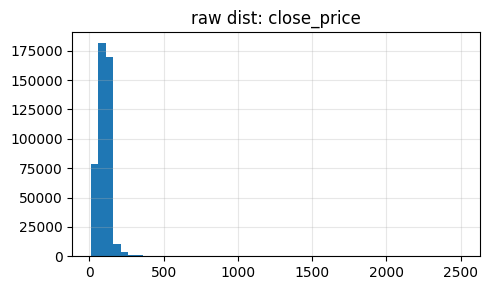

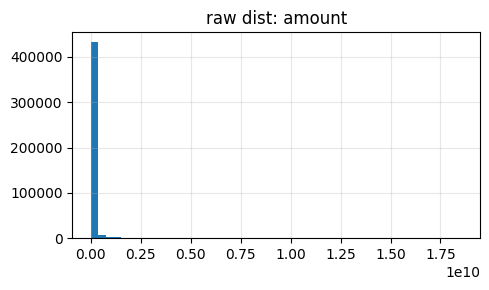

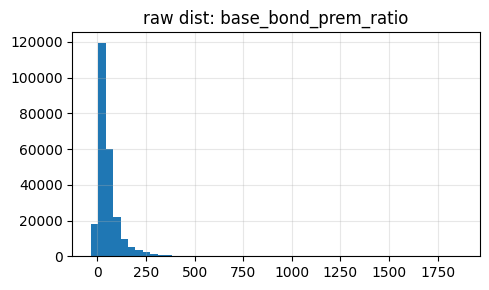

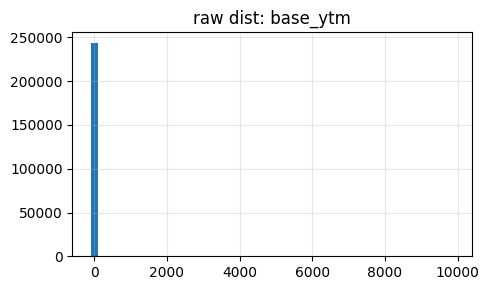

In [479]:
# Load cleaned data range
from datetime import datetime

def read_clean_range(root: Path, start_date: str, end_date: str) -> pd.DataFrame:
    frames = []
    for day in pd.date_range(start_date, end_date, freq='D'):
        month = f"{day.year:04d}-{day.month:02d}"
        path = root / month / f"{day.strftime('%Y%m%d')}.parquet"
        if path.exists():
            frames.append(pd.read_parquet(path))
    if not frames:
        return pd.DataFrame()
    return pd.concat(frames, ignore_index=True)

raw = read_clean_range(dwd_root, start, end)
print('rows:', len(raw))

# check required columns
missing = [c for c in CLEAN_REQUIRED_COLS if c not in raw.columns]
if missing:
    raise KeyError(f'missing columns: {missing}')

work = raw[CLEAN_REQUIRED_COLS].copy()
work['trade_date'] = pd.to_datetime(work['trade_date']).dt.date

print('available columns:', list(work.columns))

# plot raw feature distributions (whitelist)
for col in CLEAN_PLOT_COLS:
    if col in work.columns:
        plt.figure(figsize=(5, 3))
        work[col].hist(bins=50)
        plt.title(f'raw dist: {col}')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


## 2) Feature Engineering


feature count: 49
feature sample: ['close_price', 'prev_close_price', 'amount', 'base_bond_prem_ratio', 'base_stk_close_price', 'base_year_to_mat', 'base_ytm', 'base_in_trigger_process', 'base_conv_value', 'base_pure_redemption_value']


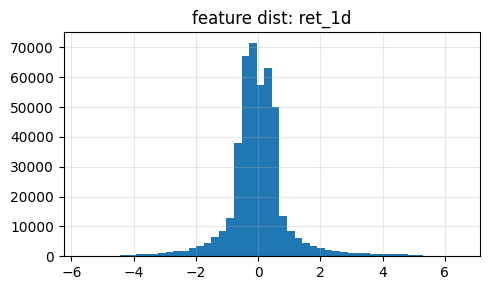

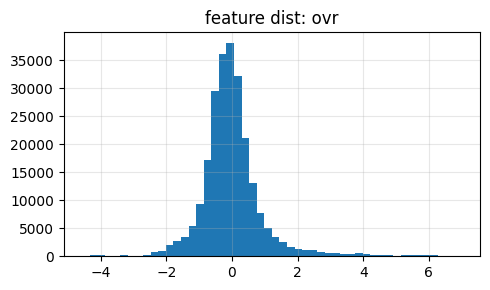

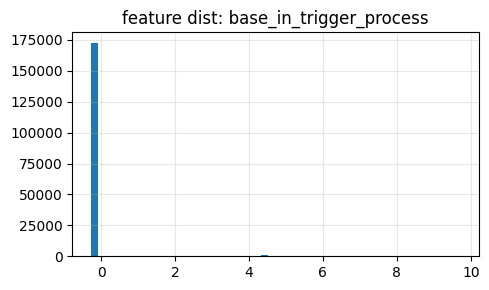

In [480]:
# base features
base_cols = [
    'close_price', 'prev_close_price', 'amount',
    'base_bond_prem_ratio', 'base_stk_close_price',
    'base_year_to_mat', 'base_ytm',
    'base_in_trigger_process', 'base_conv_value', 'base_pure_redemption_value'
]

# derived features
work['ret_1d'] = work['close_price'] / work['prev_close_price'] - 1.0
work['opt_value'] = work['close_price'] - work['base_pure_redemption_value']
work['ovr'] = work['opt_value'] / work['base_conv_value'].replace(0.0, np.nan)
work['stk_ret_1d'] = work['base_stk_close_price'] / work.groupby('code')['base_stk_close_price'].shift(1) - 1.0

# log features
log_cols = []
if USE_LOG_FEATURES:
    for col in ['amount', 'base_conv_value', 'base_pure_redemption_value', 'close_price']:
        log_col = f'log_{col}'
        work[log_col] = np.log1p(work[col].clip(lower=0))
        log_cols.append(log_col)

# EMA features (by code)
ema_cols = []
if USE_EMA_FEATURES:
    for col in EMA_COLS:
        if col not in work.columns:
            raise KeyError(f'EMA column missing: {col}')
        for span in EMA_SPANS:
            ema_col = f'ema_{col}_{span}'
            work[ema_col] = work.groupby('code')[col].transform(
                lambda s: s.ewm(span=span, adjust=False).mean()
            )
            ema_cols.append(ema_col)

# interaction features
interaction_cols = []
if USE_INTERACTION_FEATURES:
    for a, b in INTERACTION_PAIRS:
        if a not in work.columns or b not in work.columns:
            raise KeyError(f'interaction columns missing: {a}, {b}')
        col = f'{a}_x_{b}'
        work[col] = work[a] * work[b]
        interaction_cols.append(col)

# rank features
rank_cols = []
if USE_RANK_FEATURES:
    for col in RANK_COLS:
        if col not in work.columns:
            raise KeyError(f'rank column missing: {col}')
        rcol = f'rank_{col}'
        work[rcol] = work.groupby('trade_date')[col].rank(pct=True)
        rank_cols.append(rcol)

feature_cols = (
    base_cols
    + ['ret_1d', 'opt_value', 'ovr', 'stk_ret_1d']
    + log_cols
    + ema_cols
    + interaction_cols
    + rank_cols
)


# clip features by trade_date (winsorize)
if USE_FEATURE_CLIP:
    def _clip_feature(s: pd.Series) -> pd.Series:
        low, high = s.quantile(FEATURE_CLIP_Q[0]), s.quantile(FEATURE_CLIP_Q[1])
        return s.clip(lower=low, upper=high)

    clip_cols = [c for c in feature_cols if not c.startswith('rank_')]
    for col in clip_cols:
        work[col] = work.groupby('trade_date')[col].transform(_clip_feature)

# zscore by trade_date (no leakage)
if USE_ZSCORE:
    for col in feature_cols:
        work[col] = work.groupby('trade_date')[col].transform(lambda s: (s - s.mean()) / s.std(ddof=0))

work.replace([np.inf, -np.inf], np.nan, inplace=True)

print('feature count:', len(feature_cols))
print('feature sample:', feature_cols[:10])

# plot feature distributions after engineering (whitelist)
for col in FE_PLOT_COLS:
    if col in work.columns:
        plt.figure(figsize=(5, 3))
        work[col].hist(bins=50)
        plt.title(f'feature dist: {col}')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


## 3) Dataset Preparation


In [481]:
# Build label y(t+1)
work['buy_twap_t1'] = work.groupby('code')[buy_twap_col].shift(-1)
work['sell_twap_t1'] = work.groupby('code')[sell_twap_col].shift(-1)
work['y'] = work['sell_twap_t1'] / work['buy_twap_t1'] - 1.0

# clip y by daily quantiles (winsorize)
if USE_Y_CLIP:
    def _clip_by_date(s: pd.Series) -> pd.Series:
        low, high = s.quantile(Y_CLIP_Q[0]), s.quantile(Y_CLIP_Q[1])
        return s.clip(lower=low, upper=high)

    work['y_raw'] = work['y']
    work['y'] = work.groupby('trade_date')['y'].transform(_clip_by_date)

# build model_df
base_cols = ['trade_date', 'code'] + feature_cols + ['y']
if 'y_raw' in work.columns:
    base_cols.append('y_raw')
model_df = work[base_cols].dropna()
print('model rows:', len(model_df))

# Time split: train/val/test by date
all_days = sorted(model_df['trade_date'].unique())
if len(all_days) < 10:
    raise ValueError('not enough days for split')

n = len(all_days)
train_end = int(n * TRAIN_RATIO)
val_end = int(n * (TRAIN_RATIO + VAL_RATIO))

train_days = set(all_days[:train_end])
val_days = set(all_days[train_end:val_end])
test_days = set(all_days[val_end:])

train_df = model_df[model_df['trade_date'].isin(train_days)]
val_df = model_df[model_df['trade_date'].isin(val_days)]
test_df = model_df[model_df['trade_date'].isin(test_days)]

print('train/val/test rows:', len(train_df), len(val_df), len(test_df))


model rows: 174451
train/val/test rows: 111826 33297 29328


## 4) Model Build


In [482]:
import lightgbm as lgb

# apply GPU config
params = dict(MODEL_PARAMS)
if USE_GPU:
    params.update({
        'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
    })

def build_model(name: str, params: dict):
    if name == 'lgbm':
        return lgb.LGBMRegressor(**params)
    raise ValueError(f'unsupported model: {name}')


## 5) Model Training


In [483]:
from sklearn.metrics import mean_squared_error, r2_score

X_train = train_df[feature_cols]
y_train = train_df[Y_COL]
X_val = val_df[feature_cols]
y_val = val_df[Y_COL]
X_test = test_df[feature_cols]
y_test = test_df[Y_COL]

best_params = dict(params)

if TRAIN_MODE == 'optuna':
    try:
        import optuna
    except ImportError as exc:
        raise ImportError('optuna is not installed. Run: pip install optuna') from exc

    def objective(trial):
        trial_params = dict(params)
        trial_params.update({
            'lambda_l1': trial.suggest_float('lambda_l1', 1e-6, 1.0, log=True),
            'lambda_l2': trial.suggest_float('lambda_l2', 1e-6, 1.0, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 200, 2000, step=200),
            'max_depth': trial.suggest_int('max_depth', 4, 16),
            'num_leaves': trial.suggest_int('num_leaves', 16, 128, step=16),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 500, step=20),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 0, 10),
        })
        model = build_model(MODEL_NAME, trial_params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='l2',
            callbacks=[lgb.log_evaluation(0)],
        )
        pred = model.predict(X_val)
        mse = float(mean_squared_error(y_val, pred))
        r2 = float(r2_score(y_val, pred))
        acc = float((np.sign(pred) == np.sign(y_val)).mean())

        if OPTUNA_METRIC == 'mse':
            return mse
        if OPTUNA_METRIC == 'r2':
            return r2
        if OPTUNA_METRIC == 'acc':
            return acc
        raise ValueError(f'unsupported OPTUNA_METRIC: {OPTUNA_METRIC}')

    direction = 'minimize' if OPTUNA_METRIC == 'mse' else 'maximize'
    study = optuna.create_study(direction=direction)
    study.optimize(objective, n_trials=OPTUNA_TRIALS, show_progress_bar=True)

    best_params = dict(params)
    best_params.update(study.best_params)

    out_dir = root / 'results'
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / Path(OPTUNA_RESULTS_PATH).name
    payload = {
        'best_params': study.best_params,
        'best_value': float(study.best_value),
        'metric': OPTUNA_METRIC,
    }
    out_path.write_text(json.dumps(payload, ensure_ascii=False, indent=2), encoding='utf-8')
    print('saved best params:', out_path)

elif TRAIN_MODE == 'optuna_replay':
    results_path = Path(OPTUNA_RESULTS_PATH)
    if not results_path.is_absolute():
        results_path = root / results_path
    if not results_path.exists():
        raise FileNotFoundError(f'optuna results not found: {results_path}')
    payload = json.loads(results_path.read_text(encoding='utf-8'))
    best_params = dict(params)
    best_params.update(payload.get('best_params', {}))

# train final model
model = build_model(MODEL_NAME, best_params)
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_names=['train', 'val'],
    eval_metric='l2',
    callbacks=[
        lgb.early_stopping(EARLY_STOPPING_ROUNDS, verbose=False),
        lgb.log_evaluation(0),
    ],
)

best_iter = model.best_iteration_ if model.best_iteration_ is not None else model.n_estimators
print('best_iteration:', best_iter)

pred_val = model.predict(X_val, num_iteration=best_iter)
pred_test = model.predict(X_test, num_iteration=best_iter)


[I 2026-01-16 15:36:14,870] A new study created in memory with name: no-name-c2b00eee-f458-4a78-b855-dd81c8524c95
Best trial: 0. Best value: 0.000129075:   2%|▏         | 1/50 [00:14<11:53, 14.55s/it]

[I 2026-01-16 15:36:29,423] Trial 0 finished with value: 0.0001290750288451991 and parameters: {'lambda_l1': 3.782561996788831e-05, 'lambda_l2': 0.11905841626329187, 'n_estimators': 2000, 'max_depth': 14, 'num_leaves': 96, 'min_data_in_leaf': 440, 'feature_fraction': 0.7224592887918987, 'bagging_fraction': 0.8698935815797235, 'bagging_freq': 8}. Best is trial 0 with value: 0.0001290750288451991.


Best trial: 1. Best value: 0.000121991:   4%|▍         | 2/50 [00:18<06:29,  8.12s/it]

[I 2026-01-16 15:36:33,032] Trial 1 finished with value: 0.00012199072607541853 and parameters: {'lambda_l1': 0.7563787788022716, 'lambda_l2': 1.330498638296001e-05, 'n_estimators': 400, 'max_depth': 8, 'num_leaves': 112, 'min_data_in_leaf': 260, 'feature_fraction': 0.767570090663832, 'bagging_fraction': 0.7064259528716206, 'bagging_freq': 3}. Best is trial 1 with value: 0.00012199072607541853.


Best trial: 1. Best value: 0.000121991:   6%|▌         | 3/50 [00:20<04:25,  5.66s/it]

[I 2026-01-16 15:36:35,769] Trial 2 finished with value: 0.0001224193304105696 and parameters: {'lambda_l1': 0.040981053034099685, 'lambda_l2': 1.2260749150155772e-05, 'n_estimators': 200, 'max_depth': 10, 'num_leaves': 80, 'min_data_in_leaf': 140, 'feature_fraction': 0.9329390777288695, 'bagging_fraction': 0.9066901178094401, 'bagging_freq': 2}. Best is trial 1 with value: 0.00012199072607541853.


Best trial: 1. Best value: 0.000121991:   8%|▊         | 4/50 [00:30<05:28,  7.13s/it]

[I 2026-01-16 15:36:45,156] Trial 3 finished with value: 0.0001253183521843164 and parameters: {'lambda_l1': 0.43929104728921237, 'lambda_l2': 0.004240748267958124, 'n_estimators': 1000, 'max_depth': 15, 'num_leaves': 64, 'min_data_in_leaf': 320, 'feature_fraction': 0.7891520861629632, 'bagging_fraction': 0.79083579758581, 'bagging_freq': 7}. Best is trial 1 with value: 0.00012199072607541853.


Best trial: 1. Best value: 0.000121991:  10%|█         | 5/50 [00:31<03:48,  5.08s/it]

[I 2026-01-16 15:36:46,603] Trial 4 finished with value: 0.00012205497428666116 and parameters: {'lambda_l1': 0.28764350270722144, 'lambda_l2': 2.97823324927374e-05, 'n_estimators': 200, 'max_depth': 13, 'num_leaves': 32, 'min_data_in_leaf': 300, 'feature_fraction': 0.8510964401925305, 'bagging_fraction': 0.907271410210752, 'bagging_freq': 5}. Best is trial 1 with value: 0.00012199072607541853.


Best trial: 1. Best value: 0.000121991:  12%|█▏        | 6/50 [00:38<04:06,  5.59s/it]

[I 2026-01-16 15:36:53,192] Trial 5 finished with value: 0.00012470225171594415 and parameters: {'lambda_l1': 1.975055784286857e-06, 'lambda_l2': 0.014240861249656145, 'n_estimators': 1800, 'max_depth': 4, 'num_leaves': 64, 'min_data_in_leaf': 20, 'feature_fraction': 0.9049585084678662, 'bagging_fraction': 0.768194833801599, 'bagging_freq': 4}. Best is trial 1 with value: 0.00012199072607541853.


Best trial: 1. Best value: 0.000121991:  14%|█▍        | 7/50 [00:44<04:15,  5.93s/it]

[I 2026-01-16 15:36:59,821] Trial 6 finished with value: 0.00012698779919985564 and parameters: {'lambda_l1': 0.28150877733367896, 'lambda_l2': 7.481035930361502e-06, 'n_estimators': 1000, 'max_depth': 10, 'num_leaves': 96, 'min_data_in_leaf': 500, 'feature_fraction': 0.9797678591171606, 'bagging_fraction': 0.7998971766431897, 'bagging_freq': 6}. Best is trial 1 with value: 0.00012199072607541853.


Best trial: 1. Best value: 0.000121991:  16%|█▌        | 8/50 [00:48<03:43,  5.32s/it]

[I 2026-01-16 15:37:03,842] Trial 7 finished with value: 0.0001243079199116578 and parameters: {'lambda_l1': 1.285703950698925e-05, 'lambda_l2': 0.004710949126351168, 'n_estimators': 600, 'max_depth': 8, 'num_leaves': 96, 'min_data_in_leaf': 180, 'feature_fraction': 0.8112357516429919, 'bagging_fraction': 0.8122327377027908, 'bagging_freq': 3}. Best is trial 1 with value: 0.00012199072607541853.


Best trial: 1. Best value: 0.000121991:  18%|█▊        | 9/50 [01:03<05:34,  8.16s/it]

[I 2026-01-16 15:37:18,244] Trial 8 finished with value: 0.00012759303442453157 and parameters: {'lambda_l1': 0.15147206951820064, 'lambda_l2': 1.447407885752128e-05, 'n_estimators': 1400, 'max_depth': 16, 'num_leaves': 80, 'min_data_in_leaf': 100, 'feature_fraction': 0.6167817737943339, 'bagging_fraction': 0.8834212505722971, 'bagging_freq': 4}. Best is trial 1 with value: 0.00012199072607541853.


Best trial: 1. Best value: 0.000121991:  20%|██        | 10/50 [01:15<06:21,  9.53s/it]

[I 2026-01-16 15:37:30,831] Trial 9 finished with value: 0.00012699722122383496 and parameters: {'lambda_l1': 4.842462104215769e-06, 'lambda_l2': 0.00013370238816509504, 'n_estimators': 1800, 'max_depth': 16, 'num_leaves': 64, 'min_data_in_leaf': 240, 'feature_fraction': 0.9054043380750314, 'bagging_fraction': 0.6509753804971853, 'bagging_freq': 7}. Best is trial 1 with value: 0.00012199072607541853.


Best trial: 1. Best value: 0.000121991:  22%|██▏       | 11/50 [01:18<04:49,  7.41s/it]

[I 2026-01-16 15:37:33,442] Trial 10 finished with value: 0.0001235979114761957 and parameters: {'lambda_l1': 0.003944502493918129, 'lambda_l2': 1.3332522613589878e-06, 'n_estimators': 600, 'max_depth': 6, 'num_leaves': 128, 'min_data_in_leaf': 380, 'feature_fraction': 0.6900794967477998, 'bagging_fraction': 0.653821376221845, 'bagging_freq': 0}. Best is trial 1 with value: 0.00012199072607541853.


Best trial: 11. Best value: 0.000120819:  24%|██▍       | 12/50 [01:19<03:27,  5.46s/it]

[I 2026-01-16 15:37:34,448] Trial 11 finished with value: 0.00012081891751263319 and parameters: {'lambda_l1': 0.006637920831692372, 'lambda_l2': 0.00018463716177210906, 'n_estimators': 200, 'max_depth': 12, 'num_leaves': 16, 'min_data_in_leaf': 280, 'feature_fraction': 0.8207088804251295, 'bagging_fraction': 0.9827159968485967, 'bagging_freq': 10}. Best is trial 11 with value: 0.00012081891751263319.


Best trial: 11. Best value: 0.000120819:  26%|██▌       | 13/50 [01:21<02:45,  4.46s/it]

[I 2026-01-16 15:37:36,611] Trial 12 finished with value: 0.00012271788827553396 and parameters: {'lambda_l1': 0.0005859279742772702, 'lambda_l2': 0.0003163523020838614, 'n_estimators': 600, 'max_depth': 11, 'num_leaves': 16, 'min_data_in_leaf': 240, 'feature_fraction': 0.7449567916766924, 'bagging_fraction': 0.7195574503644523, 'bagging_freq': 10}. Best is trial 11 with value: 0.00012081891751263319.


Best trial: 13. Best value: 0.000120511:  28%|██▊       | 14/50 [01:23<02:08,  3.56s/it]

[I 2026-01-16 15:37:38,076] Trial 13 finished with value: 0.0001205110645735698 and parameters: {'lambda_l1': 0.010637098017173692, 'lambda_l2': 0.00016781998106787355, 'n_estimators': 200, 'max_depth': 7, 'num_leaves': 128, 'min_data_in_leaf': 340, 'feature_fraction': 0.8308521036395067, 'bagging_fraction': 0.9701823097975225, 'bagging_freq': 10}. Best is trial 13 with value: 0.0001205110645735698.


Best trial: 13. Best value: 0.000120511:  30%|███       | 15/50 [01:24<01:43,  2.96s/it]

[I 2026-01-16 15:37:39,655] Trial 14 finished with value: 0.00012198996619211292 and parameters: {'lambda_l1': 0.005958027936254957, 'lambda_l2': 0.0006996947274885529, 'n_estimators': 200, 'max_depth': 12, 'num_leaves': 32, 'min_data_in_leaf': 380, 'feature_fraction': 0.8426634140172057, 'bagging_fraction': 0.9933648314049941, 'bagging_freq': 10}. Best is trial 13 with value: 0.0001205110645735698.


Best trial: 13. Best value: 0.000120511:  32%|███▏      | 16/50 [01:29<01:54,  3.37s/it]

[I 2026-01-16 15:37:43,973] Trial 15 finished with value: 0.000124682558698382 and parameters: {'lambda_l1': 0.00022237456530556108, 'lambda_l2': 0.00015319020706344166, 'n_estimators': 800, 'max_depth': 8, 'num_leaves': 128, 'min_data_in_leaf': 360, 'feature_fraction': 0.8627512729097785, 'bagging_fraction': 0.9547788760772298, 'bagging_freq': 9}. Best is trial 13 with value: 0.0001205110645735698.


Best trial: 13. Best value: 0.000120511:  34%|███▍      | 17/50 [01:35<02:16,  4.15s/it]

[I 2026-01-16 15:37:49,927] Trial 16 finished with value: 0.00012539831158633446 and parameters: {'lambda_l1': 0.018457057417062463, 'lambda_l2': 0.13692584139671707, 'n_estimators': 1400, 'max_depth': 6, 'num_leaves': 48, 'min_data_in_leaf': 440, 'feature_fraction': 0.6817998696408538, 'bagging_fraction': 0.992911674334639, 'bagging_freq': 9}. Best is trial 13 with value: 0.0001205110645735698.


Best trial: 13. Best value: 0.000120511:  36%|███▌      | 18/50 [01:36<01:47,  3.36s/it]

[I 2026-01-16 15:37:51,443] Trial 17 finished with value: 0.0001210102854462177 and parameters: {'lambda_l1': 0.002074266661766638, 'lambda_l2': 0.001634462429464555, 'n_estimators': 400, 'max_depth': 4, 'num_leaves': 16, 'min_data_in_leaf': 200, 'feature_fraction': 0.817436031125687, 'bagging_fraction': 0.9465488013129197, 'bagging_freq': 8}. Best is trial 13 with value: 0.0001205110645735698.


Best trial: 13. Best value: 0.000120511:  38%|███▊      | 19/50 [01:41<02:00,  3.88s/it]

[I 2026-01-16 15:37:56,553] Trial 18 finished with value: 0.00012408093963710485 and parameters: {'lambda_l1': 0.00024329806718044648, 'lambda_l2': 8.023034858471186e-05, 'n_estimators': 1400, 'max_depth': 6, 'num_leaves': 48, 'min_data_in_leaf': 320, 'feature_fraction': 0.9840798216719605, 'bagging_fraction': 0.848625464558048, 'bagging_freq': 10}. Best is trial 13 with value: 0.0001205110645735698.


Best trial: 13. Best value: 0.000120511:  40%|████      | 20/50 [01:44<01:46,  3.53s/it]

[I 2026-01-16 15:37:59,272] Trial 19 finished with value: 0.0001239032719102135 and parameters: {'lambda_l1': 0.02325050618240937, 'lambda_l2': 1.2666837388261571e-06, 'n_estimators': 400, 'max_depth': 9, 'num_leaves': 112, 'min_data_in_leaf': 440, 'feature_fraction': 0.8897526736895418, 'bagging_fraction': 0.9431120873070904, 'bagging_freq': 8}. Best is trial 13 with value: 0.0001205110645735698.


Best trial: 13. Best value: 0.000120511:  42%|████▏     | 21/50 [01:48<01:45,  3.63s/it]

[I 2026-01-16 15:38:03,130] Trial 20 finished with value: 0.00012426060836900343 and parameters: {'lambda_l1': 0.0624192979845832, 'lambda_l2': 0.03710390329645628, 'n_estimators': 800, 'max_depth': 12, 'num_leaves': 32, 'min_data_in_leaf': 80, 'feature_fraction': 0.635520411307751, 'bagging_fraction': 0.601726817085675, 'bagging_freq': 6}. Best is trial 13 with value: 0.0001205110645735698.


Best trial: 13. Best value: 0.000120511:  44%|████▍     | 22/50 [01:49<01:23,  2.99s/it]

[I 2026-01-16 15:38:04,619] Trial 21 finished with value: 0.00012092039763637028 and parameters: {'lambda_l1': 0.0024662218729888173, 'lambda_l2': 0.0020157815294564447, 'n_estimators': 400, 'max_depth': 4, 'num_leaves': 16, 'min_data_in_leaf': 180, 'feature_fraction': 0.8134808537596264, 'bagging_fraction': 0.9508082332292515, 'bagging_freq': 9}. Best is trial 13 with value: 0.0001205110645735698.


Best trial: 22. Best value: 0.000119602:  46%|████▌     | 23/50 [01:50<01:04,  2.40s/it]

[I 2026-01-16 15:38:05,637] Trial 22 finished with value: 0.00011960174393360283 and parameters: {'lambda_l1': 0.009096019400800352, 'lambda_l2': 0.6245953754049919, 'n_estimators': 200, 'max_depth': 5, 'num_leaves': 16, 'min_data_in_leaf': 180, 'feature_fraction': 0.7756947775446149, 'bagging_fraction': 0.9991215655109965, 'bagging_freq': 9}. Best is trial 22 with value: 0.00011960174393360283.


Best trial: 22. Best value: 0.000119602:  48%|████▊     | 24/50 [01:52<00:54,  2.11s/it]

[I 2026-01-16 15:38:07,081] Trial 23 finished with value: 0.00012071518248896553 and parameters: {'lambda_l1': 0.007684636934990676, 'lambda_l2': 0.4509440730373413, 'n_estimators': 200, 'max_depth': 7, 'num_leaves': 48, 'min_data_in_leaf': 280, 'feature_fraction': 0.7706269382831266, 'bagging_fraction': 0.9992596050204465, 'bagging_freq': 10}. Best is trial 22 with value: 0.00011960174393360283.


Best trial: 22. Best value: 0.000119602:  50%|█████     | 25/50 [01:53<00:46,  1.86s/it]

[I 2026-01-16 15:38:08,360] Trial 24 finished with value: 0.00012111346693856239 and parameters: {'lambda_l1': 0.0007952743343754642, 'lambda_l2': 0.7502744423768677, 'n_estimators': 200, 'max_depth': 7, 'num_leaves': 48, 'min_data_in_leaf': 220, 'feature_fraction': 0.7636972471967232, 'bagging_fraction': 0.9999795146766433, 'bagging_freq': 9}. Best is trial 22 with value: 0.00011960174393360283.


Best trial: 22. Best value: 0.000119602:  52%|█████▏    | 26/50 [01:57<00:56,  2.37s/it]

[I 2026-01-16 15:38:11,907] Trial 25 finished with value: 0.0001242838583741259 and parameters: {'lambda_l1': 0.015357839225157422, 'lambda_l2': 0.9721265812039056, 'n_estimators': 800, 'max_depth': 5, 'num_leaves': 32, 'min_data_in_leaf': 140, 'feature_fraction': 0.7167661848755846, 'bagging_fraction': 0.9190510108978752, 'bagging_freq': 7}. Best is trial 22 with value: 0.00011960174393360283.


Best trial: 22. Best value: 0.000119602:  54%|█████▍    | 27/50 [01:59<00:54,  2.36s/it]

[I 2026-01-16 15:38:14,243] Trial 26 finished with value: 0.00012261915887491856 and parameters: {'lambda_l1': 0.08433328406616417, 'lambda_l2': 0.1527249461090263, 'n_estimators': 400, 'max_depth': 7, 'num_leaves': 48, 'min_data_in_leaf': 340, 'feature_fraction': 0.7828927328857187, 'bagging_fraction': 0.9674765762940749, 'bagging_freq': 10}. Best is trial 22 with value: 0.00011960174393360283.


Best trial: 22. Best value: 0.000119602:  56%|█████▌    | 28/50 [02:01<00:52,  2.41s/it]

[I 2026-01-16 15:38:16,766] Trial 27 finished with value: 0.0001235577036319906 and parameters: {'lambda_l1': 0.00018752777180053984, 'lambda_l2': 0.3260283485167693, 'n_estimators': 600, 'max_depth': 5, 'num_leaves': 80, 'min_data_in_leaf': 280, 'feature_fraction': 0.6698534841999088, 'bagging_fraction': 0.927863445868749, 'bagging_freq': 8}. Best is trial 22 with value: 0.00011960174393360283.


Best trial: 22. Best value: 0.000119602:  58%|█████▊    | 29/50 [02:03<00:42,  2.04s/it]

[I 2026-01-16 15:38:17,961] Trial 28 finished with value: 0.00012064550344506674 and parameters: {'lambda_l1': 0.009624134399238073, 'lambda_l2': 0.020665888043921884, 'n_estimators': 200, 'max_depth': 7, 'num_leaves': 112, 'min_data_in_leaf': 400, 'feature_fraction': 0.7386300729151163, 'bagging_fraction': 0.8382780561580634, 'bagging_freq': 9}. Best is trial 22 with value: 0.00011960174393360283.


Best trial: 22. Best value: 0.000119602:  60%|██████    | 30/50 [02:09<01:04,  3.24s/it]

[I 2026-01-16 15:38:23,993] Trial 29 finished with value: 0.0001259169545219895 and parameters: {'lambda_l1': 5.4497519609693146e-05, 'lambda_l2': 0.033314773385804165, 'n_estimators': 1200, 'max_depth': 9, 'num_leaves': 112, 'min_data_in_leaf': 420, 'feature_fraction': 0.7199331621301109, 'bagging_fraction': 0.848350587189964, 'bagging_freq': 8}. Best is trial 22 with value: 0.00011960174393360283.


Best trial: 22. Best value: 0.000119602:  62%|██████▏   | 31/50 [02:10<00:52,  2.79s/it]

[I 2026-01-16 15:38:25,723] Trial 30 finished with value: 0.00012405197058068307 and parameters: {'lambda_l1': 0.0015227178478959004, 'lambda_l2': 0.02980261424306465, 'n_estimators': 400, 'max_depth': 5, 'num_leaves': 128, 'min_data_in_leaf': 500, 'feature_fraction': 0.7457731908928913, 'bagging_fraction': 0.8786411103111108, 'bagging_freq': 6}. Best is trial 22 with value: 0.00011960174393360283.


Best trial: 22. Best value: 0.000119602:  64%|██████▍   | 32/50 [02:12<00:42,  2.34s/it]

[I 2026-01-16 15:38:27,006] Trial 31 finished with value: 0.00012042667460615362 and parameters: {'lambda_l1': 0.011471413442962836, 'lambda_l2': 0.3533377902284432, 'n_estimators': 200, 'max_depth': 7, 'num_leaves': 112, 'min_data_in_leaf': 400, 'feature_fraction': 0.7428520818325632, 'bagging_fraction': 0.9777928714098264, 'bagging_freq': 9}. Best is trial 22 with value: 0.00011960174393360283.


Best trial: 22. Best value: 0.000119602:  66%|██████▌   | 33/50 [02:13<00:36,  2.14s/it]

[I 2026-01-16 15:38:28,686] Trial 32 finished with value: 0.00012120188187037197 and parameters: {'lambda_l1': 0.013286939954961843, 'lambda_l2': 0.08117312119029434, 'n_estimators': 200, 'max_depth': 9, 'num_leaves': 96, 'min_data_in_leaf': 400, 'feature_fraction': 0.7446075462481017, 'bagging_fraction': 0.9701152481096862, 'bagging_freq': 9}. Best is trial 22 with value: 0.00011960174393360283.


Best trial: 22. Best value: 0.000119602:  68%|██████▊   | 34/50 [02:15<00:33,  2.09s/it]

[I 2026-01-16 15:38:30,666] Trial 33 finished with value: 0.00012491577003705327 and parameters: {'lambda_l1': 0.03920937214398434, 'lambda_l2': 0.2621932754910949, 'n_estimators': 400, 'max_depth': 7, 'num_leaves': 112, 'min_data_in_leaf': 440, 'feature_fraction': 0.7126513368944077, 'bagging_fraction': 0.7368656979788305, 'bagging_freq': 9}. Best is trial 22 with value: 0.00011960174393360283.


Best trial: 22. Best value: 0.000119602:  70%|███████   | 35/50 [02:16<00:26,  1.79s/it]

[I 2026-01-16 15:38:31,737] Trial 34 finished with value: 0.00012193055501023633 and parameters: {'lambda_l1': 0.10419856125112739, 'lambda_l2': 0.007770740817675389, 'n_estimators': 200, 'max_depth': 6, 'num_leaves': 112, 'min_data_in_leaf': 480, 'feature_fraction': 0.6477579606158004, 'bagging_fraction': 0.8917181514925658, 'bagging_freq': 7}. Best is trial 22 with value: 0.00011960174393360283.


Best trial: 22. Best value: 0.000119602:  72%|███████▏  | 36/50 [02:19<00:26,  1.92s/it]

[I 2026-01-16 15:38:33,964] Trial 35 finished with value: 0.00012251485337918332 and parameters: {'lambda_l1': 0.033533162814058874, 'lambda_l2': 0.06786335145617671, 'n_estimators': 400, 'max_depth': 8, 'num_leaves': 128, 'min_data_in_leaf': 340, 'feature_fraction': 0.7873341443431761, 'bagging_fraction': 0.8506341659604995, 'bagging_freq': 1}. Best is trial 22 with value: 0.00011960174393360283.


Best trial: 22. Best value: 0.000119602:  74%|███████▍  | 37/50 [02:21<00:27,  2.09s/it]

[I 2026-01-16 15:38:36,444] Trial 36 finished with value: 0.00012239410362420826 and parameters: {'lambda_l1': 0.009644511374063806, 'lambda_l2': 0.01456319985123786, 'n_estimators': 600, 'max_depth': 5, 'num_leaves': 96, 'min_data_in_leaf': 400, 'feature_fraction': 0.8385928437671099, 'bagging_fraction': 0.9178830568635533, 'bagging_freq': 8}. Best is trial 22 with value: 0.00011960174393360283.


Best trial: 22. Best value: 0.000119602:  76%|███████▌  | 38/50 [02:23<00:22,  1.90s/it]

[I 2026-01-16 15:38:37,914] Trial 37 finished with value: 0.00012158268824730694 and parameters: {'lambda_l1': 0.003824705251769679, 'lambda_l2': 0.23115407522848083, 'n_estimators': 200, 'max_depth': 9, 'num_leaves': 128, 'min_data_in_leaf': 360, 'feature_fraction': 0.8712742474888037, 'bagging_fraction': 0.7740685470638311, 'bagging_freq': 9}. Best is trial 22 with value: 0.00011960174393360283.


Best trial: 22. Best value: 0.000119602:  78%|███████▊  | 39/50 [02:24<00:20,  1.88s/it]

[I 2026-01-16 15:38:39,739] Trial 38 finished with value: 0.0001209181950856815 and parameters: {'lambda_l1': 0.951399910443824, 'lambda_l2': 0.0005011399074197903, 'n_estimators': 200, 'max_depth': 10, 'num_leaves': 112, 'min_data_in_leaf': 320, 'feature_fraction': 0.9431170304975905, 'bagging_fraction': 0.8145010228359615, 'bagging_freq': 7}. Best is trial 22 with value: 0.00011960174393360283.


Best trial: 22. Best value: 0.000119602:  80%|████████  | 40/50 [02:34<00:41,  4.15s/it]

[I 2026-01-16 15:38:49,180] Trial 39 finished with value: 0.00012619671654728786 and parameters: {'lambda_l1': 0.0005023228128398911, 'lambda_l2': 0.6422619740652684, 'n_estimators': 2000, 'max_depth': 7, 'num_leaves': 96, 'min_data_in_leaf': 460, 'feature_fraction': 0.758146666896885, 'bagging_fraction': 0.9715463086531398, 'bagging_freq': 5}. Best is trial 22 with value: 0.00011960174393360283.


Best trial: 22. Best value: 0.000119602:  82%|████████▏ | 41/50 [02:36<00:31,  3.53s/it]

[I 2026-01-16 15:38:51,280] Trial 40 finished with value: 0.00012292472907853797 and parameters: {'lambda_l1': 0.0010946305595346756, 'lambda_l2': 0.013894697724668559, 'n_estimators': 400, 'max_depth': 6, 'num_leaves': 128, 'min_data_in_leaf': 140, 'feature_fraction': 0.7956558567570327, 'bagging_fraction': 0.8977363163137995, 'bagging_freq': 10}. Best is trial 22 with value: 0.00011960174393360283.


Best trial: 22. Best value: 0.000119602:  84%|████████▍ | 42/50 [02:37<00:22,  2.86s/it]

[I 2026-01-16 15:38:52,578] Trial 41 finished with value: 0.00012041898398557116 and parameters: {'lambda_l1': 0.007656739261893958, 'lambda_l2': 0.38092791559299977, 'n_estimators': 200, 'max_depth': 7, 'num_leaves': 64, 'min_data_in_leaf': 280, 'feature_fraction': 0.7783069684125743, 'bagging_fraction': 0.9369305633932012, 'bagging_freq': 10}. Best is trial 22 with value: 0.00011960174393360283.


Best trial: 22. Best value: 0.000119602:  86%|████████▌ | 43/50 [02:39<00:17,  2.48s/it]

[I 2026-01-16 15:38:54,171] Trial 42 finished with value: 0.00012065083040863986 and parameters: {'lambda_l1': 0.24016033949930218, 'lambda_l2': 0.07431737521616097, 'n_estimators': 200, 'max_depth': 8, 'num_leaves': 80, 'min_data_in_leaf': 300, 'feature_fraction': 0.7313400215988712, 'bagging_fraction': 0.9436564313860643, 'bagging_freq': 9}. Best is trial 22 with value: 0.00011960174393360283.


Best trial: 22. Best value: 0.000119602:  88%|████████▊ | 44/50 [02:41<00:14,  2.46s/it]

[I 2026-01-16 15:38:56,567] Trial 43 finished with value: 0.0001227736554426835 and parameters: {'lambda_l1': 0.003545428000309456, 'lambda_l2': 0.35965104769547057, 'n_estimators': 400, 'max_depth': 8, 'num_leaves': 112, 'min_data_in_leaf': 400, 'feature_fraction': 0.7062424523631313, 'bagging_fraction': 0.9323062651830347, 'bagging_freq': 10}. Best is trial 22 with value: 0.00011960174393360283.


Best trial: 22. Best value: 0.000119602:  90%|█████████ | 45/50 [02:42<00:09,  1.97s/it]

[I 2026-01-16 15:38:57,403] Trial 44 finished with value: 0.00011984428859350051 and parameters: {'lambda_l1': 0.030824958212266433, 'lambda_l2': 4.1247300959727754e-05, 'n_estimators': 200, 'max_depth': 4, 'num_leaves': 64, 'min_data_in_leaf': 260, 'feature_fraction': 0.7740699550927244, 'bagging_fraction': 0.9736837149383072, 'bagging_freq': 8}. Best is trial 22 with value: 0.00011960174393360283.


Best trial: 22. Best value: 0.000119602:  92%|█████████▏| 46/50 [02:44<00:08,  2.04s/it]

[I 2026-01-16 15:38:59,615] Trial 45 finished with value: 0.00012199924215344551 and parameters: {'lambda_l1': 0.027854446648947297, 'lambda_l2': 4.9722833978548576e-05, 'n_estimators': 600, 'max_depth': 4, 'num_leaves': 64, 'min_data_in_leaf': 260, 'feature_fraction': 0.778397448274579, 'bagging_fraction': 0.9792127681693561, 'bagging_freq': 8}. Best is trial 22 with value: 0.00011960174393360283.


Best trial: 22. Best value: 0.000119602:  94%|█████████▍| 47/50 [02:53<00:12,  4.02s/it]

[I 2026-01-16 15:39:08,261] Trial 46 finished with value: 0.0001265798295171493 and parameters: {'lambda_l1': 0.0636420317089516, 'lambda_l2': 8.193363937949236e-06, 'n_estimators': 1800, 'max_depth': 5, 'num_leaves': 64, 'min_data_in_leaf': 240, 'feature_fraction': 0.7991230380996583, 'bagging_fraction': 0.9614413004355403, 'bagging_freq': 3}. Best is trial 22 with value: 0.00011960174393360283.


Best trial: 22. Best value: 0.000119602:  96%|█████████▌| 48/50 [02:55<00:06,  3.48s/it]

[I 2026-01-16 15:39:10,479] Trial 47 finished with value: 0.00012340258530897492 and parameters: {'lambda_l1': 0.15626198923386517, 'lambda_l2': 2.0951775459540178e-05, 'n_estimators': 200, 'max_depth': 14, 'num_leaves': 80, 'min_data_in_leaf': 180, 'feature_fraction': 0.8306414321685165, 'bagging_fraction': 0.9118263781668355, 'bagging_freq': 10}. Best is trial 22 with value: 0.00011960174393360283.


Best trial: 22. Best value: 0.000119602:  98%|█████████▊| 49/50 [02:57<00:02,  2.91s/it]

[I 2026-01-16 15:39:12,066] Trial 48 finished with value: 0.00012168408350541373 and parameters: {'lambda_l1': 0.3966603340172875, 'lambda_l2': 2.87181159110309e-05, 'n_estimators': 400, 'max_depth': 4, 'num_leaves': 80, 'min_data_in_leaf': 300, 'feature_fraction': 0.8584159488708076, 'bagging_fraction': 0.982124345637836, 'bagging_freq': 8}. Best is trial 22 with value: 0.00011960174393360283.


Best trial: 22. Best value: 0.000119602: 100%|██████████| 50/50 [03:02<00:00,  3.66s/it]


[I 2026-01-16 15:39:17,694] Trial 49 finished with value: 0.00012518567192819677 and parameters: {'lambda_l1': 0.006025520704522342, 'lambda_l2': 5.0385625779516665e-06, 'n_estimators': 1200, 'max_depth': 6, 'num_leaves': 64, 'min_data_in_leaf': 260, 'feature_fraction': 0.7616968536430693, 'bagging_fraction': 0.934632678822423, 'bagging_freq': 5}. Best is trial 22 with value: 0.00011960174393360283.
saved best params: c:\Users\BaiYang\CBOND_DAY\results\optuna_best_params.json
best_iteration: 24


## 6) Evaluation


{'best_iteration': 24, 'val_r2': -0.00017881003186159816, 'val_rmse': 0.01080313881469253, 'test_r2': -0.018957261559815697, 'test_rmse': 0.010815760024110421, 'val_dir_acc': 0.504489893984443, 'test_dir_acc': 0.48080332787779595}


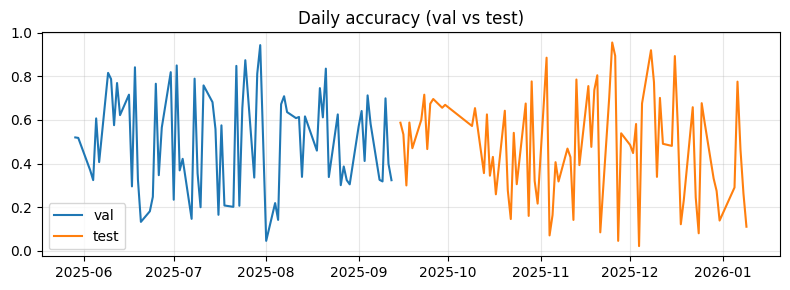

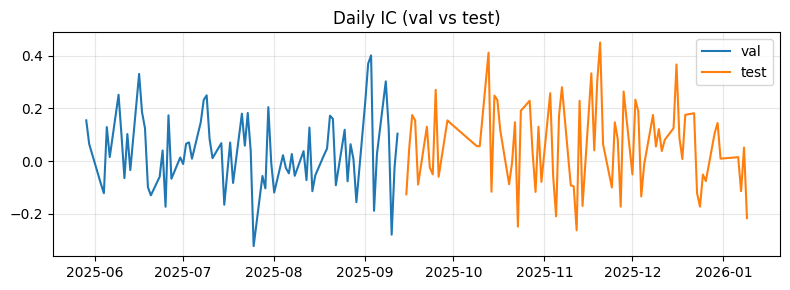

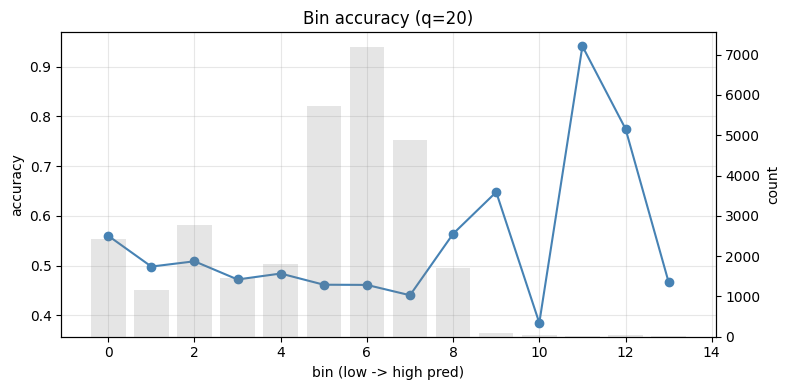

bin value counts: {0: 2433, 1: 1165, 2: 2765, 3: 1460, 4: 1798, 5: 5737, 6: 7193, 7: 4884, 8: 1694, 9: 88, 10: 39, 11: 17, 12: 40, 13: 15}
daily sample size stats: {'count': 77.0, 'mean': 380.8831168831169, 'std': 13.997155750529448, 'min': 360.0, '25%': 368.0, '50%': 382.0, '75%': 394.0, 'max': 407.0}
base_in_trigger_process          196
amount                            16
ema_amount_5                      15
ret_1d_x_base_bond_prem_ratio     14
log_amount                        13
dtype: int32


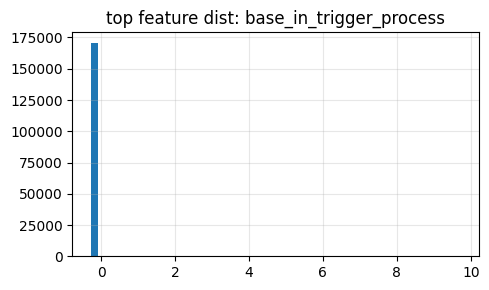

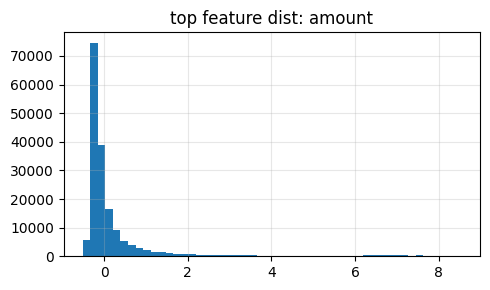

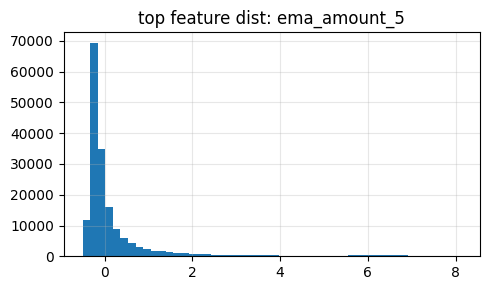

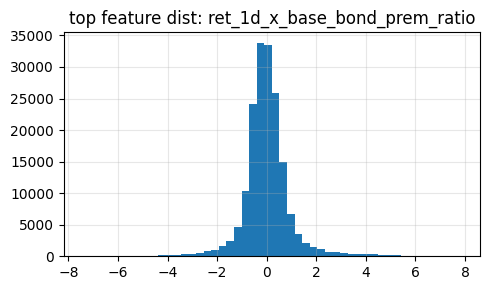

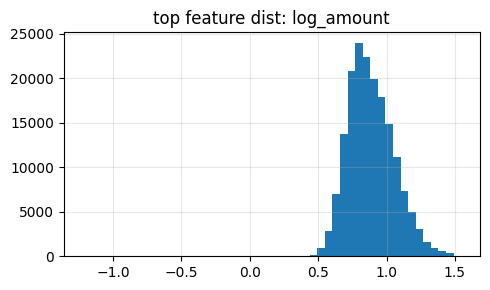

In [484]:
from sklearn.metrics import mean_squared_error, r2_score

# overall metrics
val_dir_acc = float((np.sign(pred_val) == np.sign(y_val)).mean())
test_dir_acc = float((np.sign(pred_test) == np.sign(y_test)).mean())

metrics = {
    'best_iteration': int(best_iter),
    'val_r2': r2_score(y_val, pred_val),
    'val_rmse': mean_squared_error(y_val, pred_val) ** 0.5,
    'test_r2': r2_score(y_test, pred_test),
    'test_rmse': mean_squared_error(y_test, pred_test) ** 0.5,
    'val_dir_acc': val_dir_acc,
    'test_dir_acc': test_dir_acc,
}
print(metrics)

# daily metrics (accuracy + IC)
val_eval = val_df[['trade_date']].copy()
val_eval['y'] = y_val.values
val_eval['pred'] = pred_val
val_eval['sign_hit'] = (np.sign(val_eval['pred']) == np.sign(val_eval['y'])).astype(int)

test_eval = test_df[['trade_date']].copy()
test_eval['y'] = y_test.values
test_eval['pred'] = pred_test
test_eval['sign_hit'] = (np.sign(test_eval['pred']) == np.sign(test_eval['y'])).astype(int)

def _daily_ic(df):
    if df['pred'].nunique() <= 1:
        return np.nan
    return df['pred'].corr(df['y'])

daily_val = val_eval.groupby('trade_date').apply(
    lambda g: pd.Series({
        'acc': g['sign_hit'].mean(),
        'ic': _daily_ic(g),
    })
).reset_index()

daily_test = test_eval.groupby('trade_date').apply(
    lambda g: pd.Series({
        'acc': g['sign_hit'].mean(),
        'ic': _daily_ic(g),
    })
).reset_index()

if PLOT_DAILY_METRICS:
    plt.figure(figsize=(8, 3))
    plt.plot(daily_val['trade_date'], daily_val['acc'], label='val')
    plt.plot(daily_test['trade_date'], daily_test['acc'], label='test')
    plt.title('Daily accuracy (val vs test)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 3))
    plt.plot(daily_val['trade_date'], daily_val['ic'], label='val')
    plt.plot(daily_test['trade_date'], daily_test['ic'], label='test')
    plt.title('Daily IC (val vs test)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# bin analysis by prediction (accuracy per bin, on test set)
df_bins = test_df[['trade_date', 'code']].copy()
df_bins['y'] = y_test.values
df_bins['pred'] = pred_test

def _assign_bins(day_df):
    if len(day_df) < BIN_COUNT:
        return None
    bins = pd.qcut(day_df['pred'], q=BIN_COUNT, labels=False, duplicates='drop')
    if bins is None or bins.isna().all():
        return None
    day_df = day_df.copy()
    day_df['bin'] = bins
    day_df['sign_hit'] = (np.sign(day_df['pred']) == np.sign(day_df['y'])).astype(int)
    return day_df

parts = []
for d, g in df_bins.groupby('trade_date'):
    out = _assign_bins(g)
    if out is not None and 'bin' in out.columns:
        parts.append(out)

if not parts:
    print('no valid days for binning')
else:
    df_bins = pd.concat(parts, ignore_index=True)
    grouped = df_bins.groupby('bin').agg(
        acc=('sign_hit', 'mean'),
        count=('sign_hit', 'size'),
    ).reset_index()

    fig, ax1 = plt.subplots(figsize=(8, 4))
    ax1.plot(grouped['bin'], grouped['acc'], marker='o', color='steelblue')
    ax1.set_xlabel('bin (low -> high pred)')
    ax1.set_ylabel('accuracy')
    ax1.set_title(f'Bin accuracy (q={BIN_COUNT})')
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    ax2.bar(grouped['bin'], grouped['count'], alpha=0.2, color='gray')
    ax2.set_ylabel('count')
    plt.tight_layout()
    plt.show()

    
    # diagnostics
    print('bin value counts:', df_bins['bin'].value_counts().sort_index().to_dict())
    print('daily sample size stats:', df_bins.groupby('trade_date').size().describe().to_dict())
# feature importance (top N) and distributions
importances = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=False)
print(importances.head(TOPN_FEATURES))

if PLOT_TOPN_FEATURES:
    top_cols = importances.head(TOPN_FEATURES).index.tolist()
    for col in top_cols:
        plt.figure(figsize=(5, 3))
        model_df[col].hist(bins=50)
        plt.title(f'top feature dist: {col}')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
